### Classification Result:

In [7]:
import pandas as pd
import glob
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.gridspec import GridSpec

In [8]:
def extract_model_info(filename):
    """Extract version and model info from filename with better pattern matching"""
    # Model type abbreviations
    model_types = {
        'distilbert': 'DB',
        'bert': 'BERT',
        'roberta': 'RBT',
        'regnet_y_32gf': 'RN32',
        'regnet_y_16gf': 'RN16',
        'Linear': 'Lin',
        'vit': 'VIT'
    }
    
    # Extract components
    patterns = {
        'version': r'(\d+\.\d+\.?\d+\.?\d*)',
        'run': r'(\d+(?:rd|th)Run)',
        'optimizer': r'(CustomOptimizer)',
    }
    
    components = []
    
    # Get version
    version_match = re.search(patterns['version'], filename)
    if version_match:
        components.append(f"v{version_match.group(1)}")
    
    # Get special run
    run_match = re.search(patterns['run'], filename)
    if run_match:
        components.append(run_match.group(1))
    
    # Get optimizer
    if 'CustomOptimizer' in filename:
        components.append('CustomOpt')
    
    # Get model types
    for model, abbrev in model_types.items():
        if model.lower() in filename.lower():
            components.append(abbrev)
    
    return '_'.join(components) if components else f"model_{hash(filename)}"

def investigate_nans(df, model_id):
    """Investigate NaN values for a specific model"""
    pred_col = f'prediction_{model_id}'
    print(f"\nAnalyzing {model_id}:")
    print(f"Total rows: {len(df)}")
    print(f"NaN count: {df[pred_col].isna().sum()}")
    if df[pred_col].isna().any():
        print("\nSample rows with NaN:")
        nan_samples = df[df[pred_col].isna()].head()
        print(nan_samples[['sample_id', 'text', 'true_label', pred_col]])

def normalize_text(df):
    """Normalize text column to ensure consistent format"""
    df['text'] = df['text'].str.lower().str.strip()
    return df
def merge_test_results(base_path='./', pattern='test_classification_results_*.json'):
    """Merge test results using only unique identifiers"""
    # Use only unique identifiers for merging
    merge_keys = ['sample_id', 'image_path', 'true_label']
    keep_cols = merge_keys + ['text']
    
    json_files = sorted(glob.glob(os.path.join(base_path, pattern)))
    if not json_files:
        raise ValueError(f"No files found matching pattern: {pattern}")
    
    # Process files
    dfs = []
    for file in json_files:
        try:
            df = pd.read_json(file)
            model_id = extract_model_info(file)
            
            # Normalize text but don't use for merging
            df['text'] = df['text'].str.lower().str.strip()
            
            df = df.rename(columns={
                'predicted_label': f'prediction_{model_id}',
                'correct': f'correct_{model_id}'
            })
            
            pred_col = f'prediction_{model_id}'
            df[pred_col] = pd.to_numeric(df[pred_col], errors='coerce')
            
            cols_to_keep = keep_cols + [f'prediction_{model_id}', f'correct_{model_id}']
            dfs.append(df[cols_to_keep])
            
            print(f"\nProcessing {file}:")
            print(f"Rows: {len(df)}")
            print("Unique values in merge keys:")
            for col in merge_keys:
                print(f"{col}: {df[col].nunique()} unique values")
            
        except Exception as e:
            print(f"Error processing {file}: {str(e)}")
            continue
    
    if not dfs:
        raise ValueError("No valid DataFrames to merge")
    
    # Merge using only unique identifiers
    base_df = dfs[0]
    for idx, df in enumerate(dfs[1:], 1):
        print(f"\nMerge step {idx}:")
        print(f"Left rows: {len(base_df)}")
        print(f"Right rows: {len(df)}")
        
        base_df = base_df.merge(df, on=merge_keys, how='inner')
        
        # Keep only one text column
        if 'text_y' in base_df.columns:
            base_df.drop('text_y', axis=1, inplace=True)
            base_df.rename(columns={'text_x': 'text'}, inplace=True)
            
        print(f"After merge: {len(base_df)} rows")
    
    return base_df


def clean_results(df):
    """Clean and combine results more efficiently"""
    # Standardize text
    df['text'] = df['text'].str.lower().str.strip()
    
    # Get column types
    pred_cols = [col for col in df.columns if col.startswith(('prediction_', 'correct_'))]
    id_cols = ['sample_id', 'text', 'true_label', 'image_path']
    
    # Group and combine
    def combine_row(group):
        result = group.iloc[0].copy()
        for col in pred_cols:
            valid_values = group[col].dropna()
            if not valid_values.empty:
                result[col] = valid_values.iloc[0]
        return result
    
    # Apply cleaning
    cleaned_df = (df.groupby(id_cols, as_index=False)
                   .apply(combine_row)
                   .reset_index(drop=True))
    
    # Remove unnecessary columns
    for col in ['class_name', 'index']:
        if col in cleaned_df.columns:
            cleaned_df = cleaned_df.drop(col, axis=1)
    
    print(f"Rows before cleaning: {len(df)}")
    print(f"Rows after cleaning: {len(cleaned_df)}")
    
    return cleaned_df

# Execute
try:
    # Merge results
    merged_df = merge_test_results()
    
    # Clean results
    merged_results = clean_results(merged_df)
    
    # Display results
    display(merged_results.head())
    
    
except Exception as e:
    print(f"Error in processing: {str(e)}")


Processing ./test_classification_results_1.4.2_train_test_caption_only_WithoutStopword.json:
Rows: 3431
Unique values in merge keys:
sample_id: 3431 unique values
image_path: 3431 unique values
true_label: 4 unique values

Processing ./test_classification_results_train_test_1.1.1.2_text_only_distilbert.4thRun_CustomOptimizer.json:
Rows: 3431
Unique values in merge keys:
sample_id: 3431 unique values
image_path: 3431 unique values
true_label: 4 unique values

Processing ./test_classification_results_train_test_1.1.1.3_text_only_distilbert.json:
Rows: 3431
Unique values in merge keys:
sample_id: 3431 unique values
image_path: 3431 unique values
true_label: 4 unique values

Processing ./test_classification_results_train_test_1.1.1_text_only_distilbert.3rdRun.json:
Rows: 3431
Unique values in merge keys:
sample_id: 3431 unique values
image_path: 3431 unique values
true_label: 4 unique values

Processing ./test_classification_results_train_test_1.1.2_text_only_distilbert_nostopword.json:
R

/tmp/ipykernel_2305528/3335727567.py:141: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cleaned_df = (df.groupby(id_cols, as_index=False)


,sample_id,image_path,true_label,text,prediction_v1.4.2,correct_v1.4.2,prediction_v1.1.1.2_4thRun_CustomOpt_DB_BERT,correct_v1.1.1.2_4thRun_CustomOpt_DB_BERT,prediction_v1.1.1.3_DB_BERT,correct_v1.1.1.3_DB_BERT,...,prediction_v4.2.2_BERT_Lin,correct_v4.2.2_BERT_Lin,prediction_v4.2.3_BERT_Lin,correct_v4.2.3_BERT_Lin,prediction_v4.2.4_BERT_Lin,correct_v4.2.4_BERT_Lin,prediction_BERT_Lin_y,correct_BERT_Lin_y,prediction_DB_BERT_Lin,correct_DB_BERT_Lin
0,/work/TALC/enel645_2024f/garbage_data/CVPR_202...,/work/TALC/enel645_2024f/garbage_data/CVPR_202...,0,air freshener,0,True,3,False,3,False,...,3,False,3,False,3,False,3,False,3,False
1,/work/TALC/enel645_2024f/garbage_data/CVPR_202...,/work/TALC/enel645_2024f/garbage_data/CVPR_202...,0,bottle cap,0,True,0,True,3,False,...,0,True,0,True,0,True,0,True,0,True
2,/work/TALC/enel645_2024f/garbage_data/CVPR_202...,/work/TALC/enel645_2024f/garbage_data/CVPR_202...,0,broken glass,1,False,0,True,3,False,...,1,False,0,True,0,True,0,True,0,True
3,/work/TALC/enel645_2024f/garbage_data/CVPR_202...,/work/TALC/enel645_2024f/garbage_data/CVPR_202...,0,broken glass cup,1,False,3,False,3,False,...,3,False,3,False,3,False,3,False,1,False
4,/work/TALC/enel645_2024f/garbage_data/CVPR_202...,/work/TALC/enel645_2024f/garbage_data/CVPR_202...,0,chocolate wrapper,0,True,0,True,0,True,...,0,True,0,True,0,True,0,True,0,True


Available columns: ['sample_id', 'image_path', 'true_label', 'text', 'prediction_v1.4.2', 'correct_v1.4.2', 'prediction_v1.1.1.2_4thRun_CustomOpt_DB_BERT', 'correct_v1.1.1.2_4thRun_CustomOpt_DB_BERT', 'prediction_v1.1.1.3_DB_BERT', 'correct_v1.1.1.3_DB_BERT', 'prediction_v1.1.1_3rdRun_DB_BERT', 'correct_v1.1.1_3rdRun_DB_BERT', 'prediction_v1.1.2_DB_BERT', 'correct_v1.1.2_DB_BERT', 'prediction_v1.1.2_BERT_RBT', 'correct_v1.1.2_BERT_RBT', 'prediction_v1.1.3', 'correct_v1.1.3', 'prediction_v1.1.4_BERT', 'correct_v1.1.4_BERT', 'prediction_v1.1.5.2_BERT', 'correct_v1.1.5.2_BERT', 'prediction_v1.1.5_BERT', 'correct_v1.1.5_BERT', 'prediction_model_-323128433669371297', 'correct_model_-323128433669371297', 'prediction_v1.3.1_DB_BERT', 'correct_v1.3.1_DB_BERT', 'prediction_v1.3.2_BERT', 'correct_v1.3.2_BERT', 'prediction_model_4234450963177755209', 'correct_model_4234450963177755209', 'prediction_v2.01', 'correct_v2.01', 'prediction_v2.02', 'correct_v2.02', 'prediction_v2.03', 'correct_v2.03', 

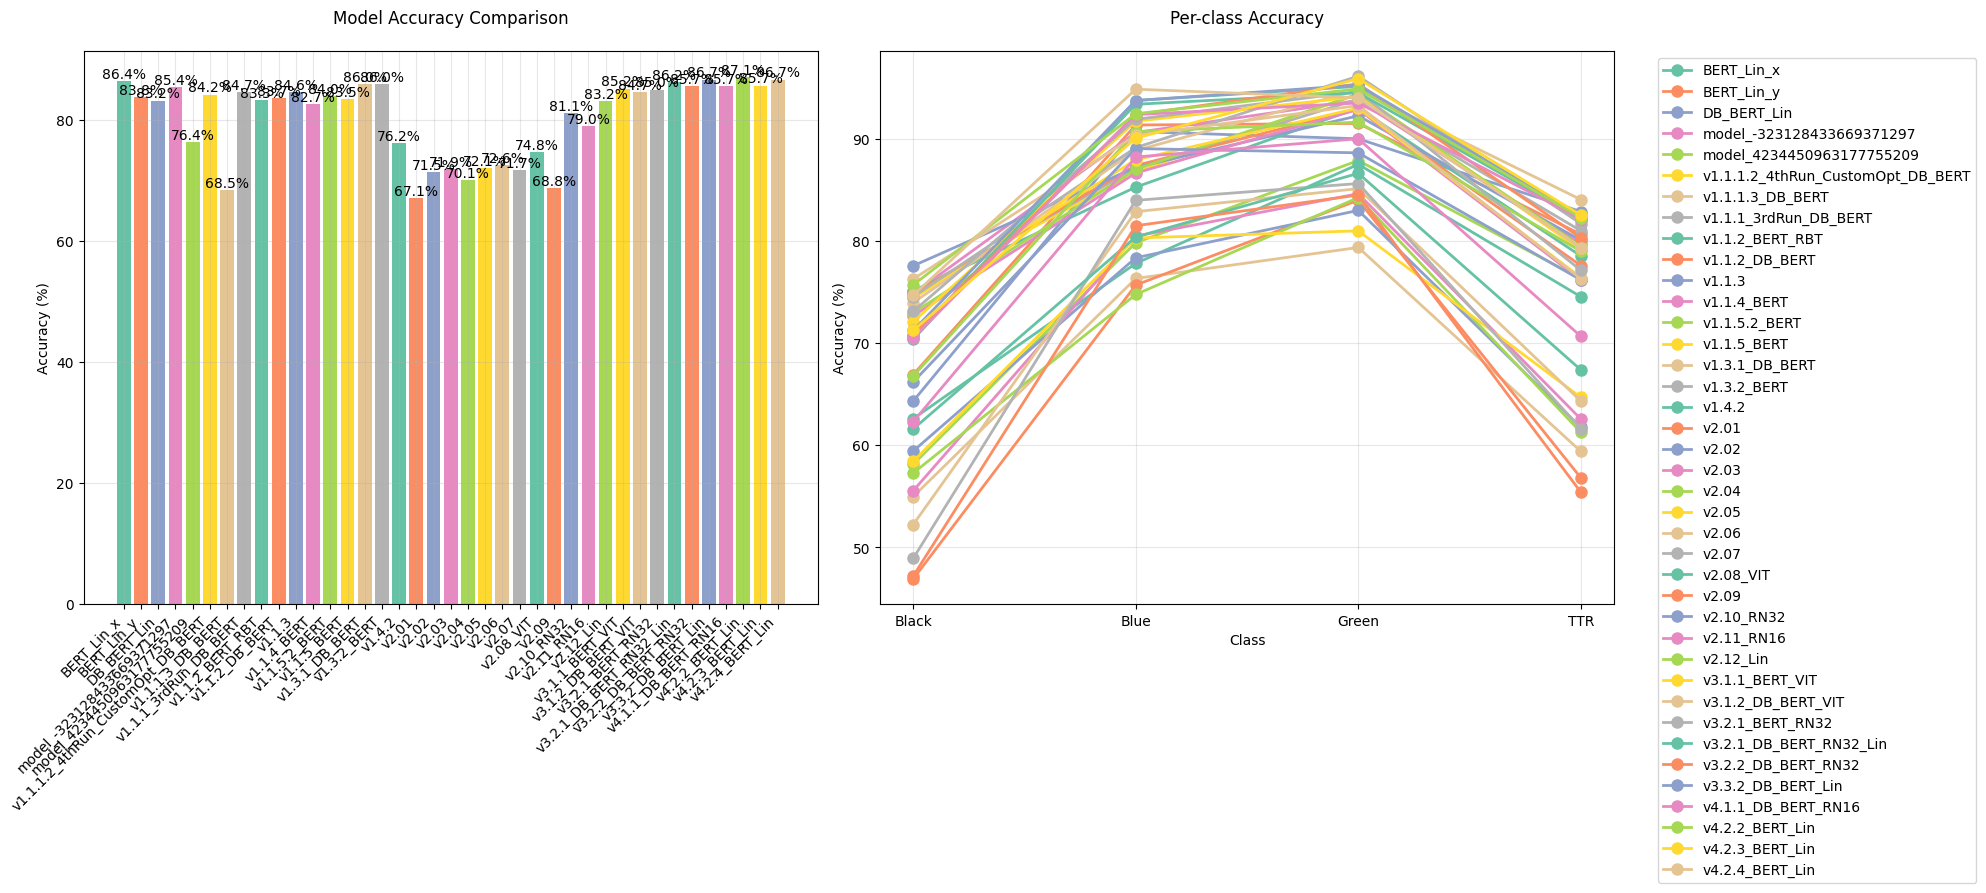

In [9]:
def get_model_names(df):
    """Extract model names from prediction columns"""
    # Look for both '_' and '$$' patterns in column names
    pred_cols = [col for col in df.columns if col.startswith('prediction_')]
    
    if not pred_cols:
        raise ValueError("No prediction columns found")
        
    # Extract model names after 'prediction_'
    model_names = [col.split('prediction_')[1] for col in pred_cols]

    model_names.sort()
    return model_names

def plot_model_comparisons(merged_df, model_names):
    plt.style.use('default')
    colors = sns.color_palette("Set2", len(model_names))
    
    # Create mapping for numeric labels to class names
    label_map = {0: 'Black', 1: 'Blue', 2: 'Green', 3: 'TTR'}
    
    # Convert numeric labels to class names
    df_plot = merged_df.copy()
    df_plot['true_label'] = df_plot['true_label'].map(label_map)
    
    fig = plt.figure(figsize=(20, 15))
    gs = GridSpec(2, 2, figure=fig)
    
    # 1. Accuracy Comparison (same as before)
    ax1 = fig.add_subplot(gs[0, 0])
    accuracies = {}
    for model in model_names:
        accuracies[model] = merged_df[f'correct_{model}'].mean() * 100
    
    bars = ax1.bar(range(len(accuracies)), accuracies.values(), color=colors)
    ax1.set_xticks(range(len(accuracies)))
    ax1.set_xticklabels(accuracies.keys(), rotation=45, ha='right')
    ax1.set_title('Model Accuracy Comparison', fontsize=12, pad=20)
    ax1.set_ylabel('Accuracy (%)')
    ax1.grid(True, alpha=0.3)
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom')
    
    # 2. Per-class Accuracy with fixed class handling
    ax2 = fig.add_subplot(gs[0, 1])
    class_names = ['Black', 'Blue', 'Green', 'TTR']
    
    for i, model in enumerate(model_names):
        class_acc = []
        for class_name in class_names:
            # Use converted class names for masking
            mask = df_plot['true_label'] == class_name
            if mask.any():  # Check if we have data for this class
                acc = df_plot[mask][f'correct_{model}'].mean() * 100
                class_acc.append(acc)
            else:
                class_acc.append(0)  # or np.nan if you prefer
                print(f"No data found for {class_name} in {model}")
                
        ax2.plot(class_names, class_acc, marker='o', color=colors[i], 
                label=model, linewidth=2, markersize=8)
    
    ax2.set_title('Per-class Accuracy', fontsize=12, pad=20)
    ax2.set_xlabel('Class')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Execute
try:
    # Print columns for debugging
    print("Available columns:", merged_results.columns.tolist())
    
    # Extract model names
    model_names = get_model_names(merged_results)
    print(f"Found models: {model_names}")
    
    # Plot comparisons
    plot_model_comparisons(merged_results, model_names)
    
except Exception as e:
    print(f"Error: {str(e)}\n")
    print("Debug info:")
    print("Column names:", merged_results.columns.tolist())

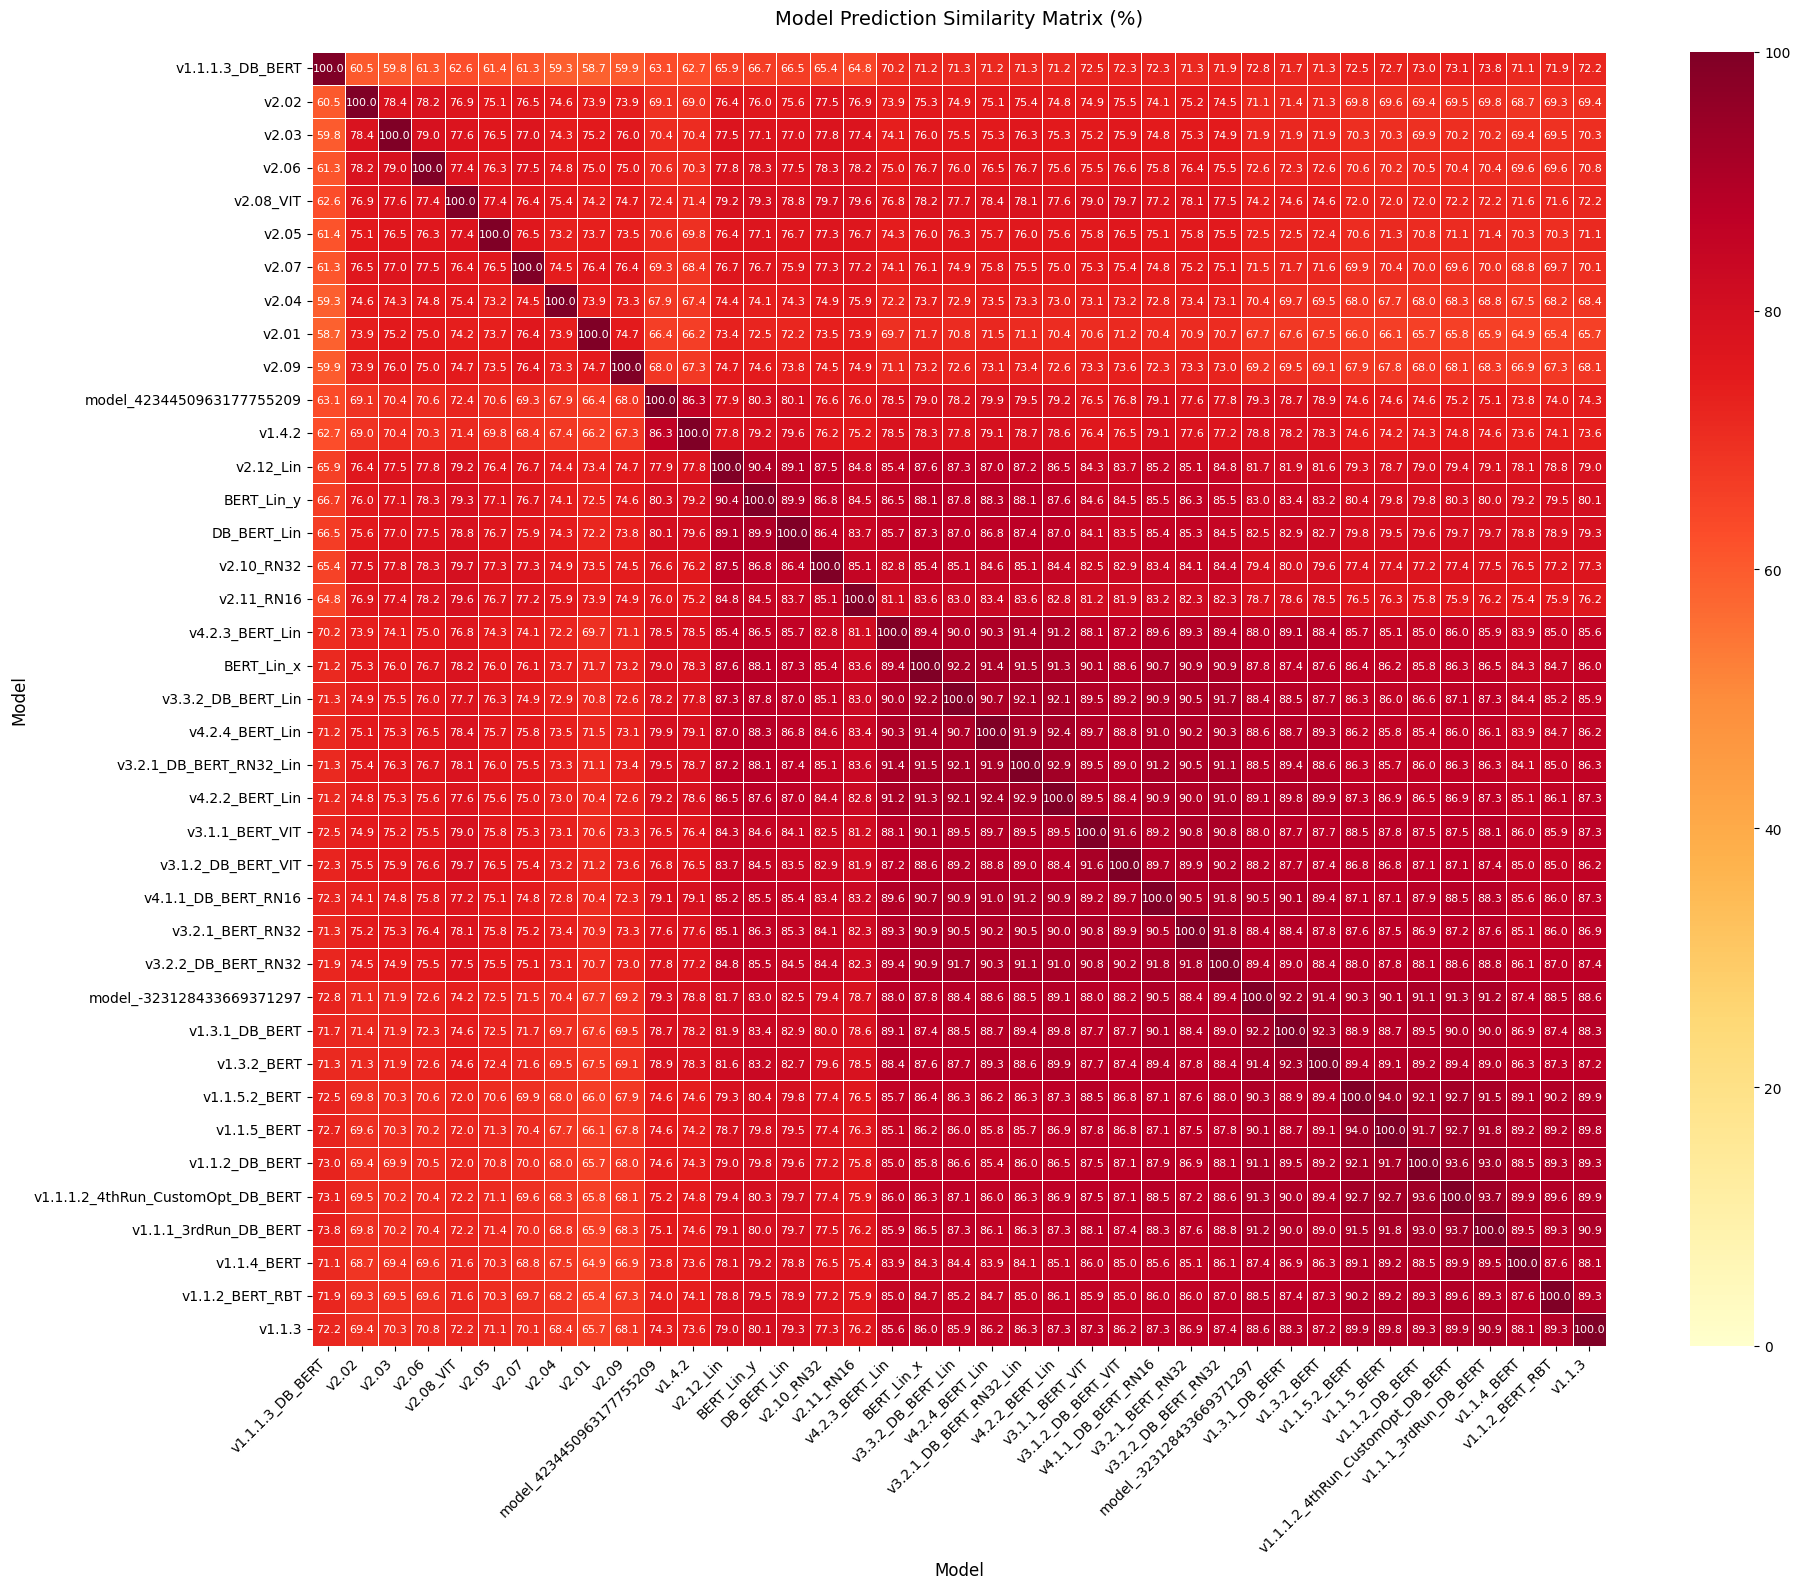


Most similar model pairs (excluding self-comparisons):
v1.1.5.2_BERT        - v1.1.5_BERT         : 94.0%
v1.1.1.2_4thRun_CustomOpt_DB_BERT - v1.1.1_3rdRun_DB_BERT: 93.7%
v1.1.1.2_4thRun_CustomOpt_DB_BERT - v1.1.2_DB_BERT      : 93.6%
v1.1.1_3rdRun_DB_BERT - v1.1.2_DB_BERT      : 93.0%
v3.2.1_DB_BERT_RN32_Lin - v4.2.2_BERT_Lin     : 92.9%


In [10]:
def plot_model_similarity(merged_df, model_names):
    """Plot enhanced similarity matrix between model predictions"""
    try:
        plt.figure(figsize=(20, 16))
        n_models = len(model_names)
        similarity_matrix = np.zeros((n_models, n_models))
        
        # Calculate similarities
        for i, model1 in enumerate(model_names):
            for j, model2 in enumerate(model_names):
                # Calculate agreement excluding NaN values
                valid_mask = merged_df[[f'prediction_{model1}', f'prediction_{model2}']].notna().all(axis=1)
                if valid_mask.any():
                    matches = (merged_df[valid_mask][f'prediction_{model1}'] == 
                             merged_df[valid_mask][f'prediction_{model2}'])
                    similarity_matrix[i, j] = matches.mean() * 100
        
        # Create DataFrame with model names
        similarity_df = pd.DataFrame(
            similarity_matrix,
            index=model_names,
            columns=model_names
        )
        
        # Cluster similar models
        if len(model_names) > 2:
            from scipy.cluster import hierarchy
            linkage = hierarchy.linkage(similarity_matrix, method='ward')
            order = hierarchy.leaves_list(linkage)
            clustered_df = similarity_df.iloc[order, order]
        else:
            clustered_df = similarity_df
        
        # Enhanced heatmap
        sns.heatmap(clustered_df, 
                   annot=True, 
                   fmt='.1f', 
                   cmap='YlOrRd',
                   vmin=0,
                   vmax=100,
                   square=True,
                   linewidths=0.5,
                   annot_kws={'size': 8})
        
        plt.title('Model Prediction Similarity Matrix (%)', pad=20, size=14)
        plt.xlabel('Model', size=12)
        plt.ylabel('Model', size=12)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
        
        # Print interesting findings
        print("\nMost similar model pairs (excluding self-comparisons):")
        pairs = []
        for i in range(n_models):
            for j in range(i+1, n_models):
                pairs.append((
                    model_names[i],
                    model_names[j],
                    similarity_matrix[i,j]
                ))
        
        for model1, model2, sim in sorted(pairs, key=lambda x: x[2], reverse=True)[:5]:
            print(f"{model1:<20} - {model2:<20}: {sim:.1f}%")
            
    except Exception as e:
        print(f"Error plotting similarity matrix: {str(e)}")
        print("Available columns:", merged_df.columns.tolist())

# Execute
plot_model_similarity(merged_results, model_names)

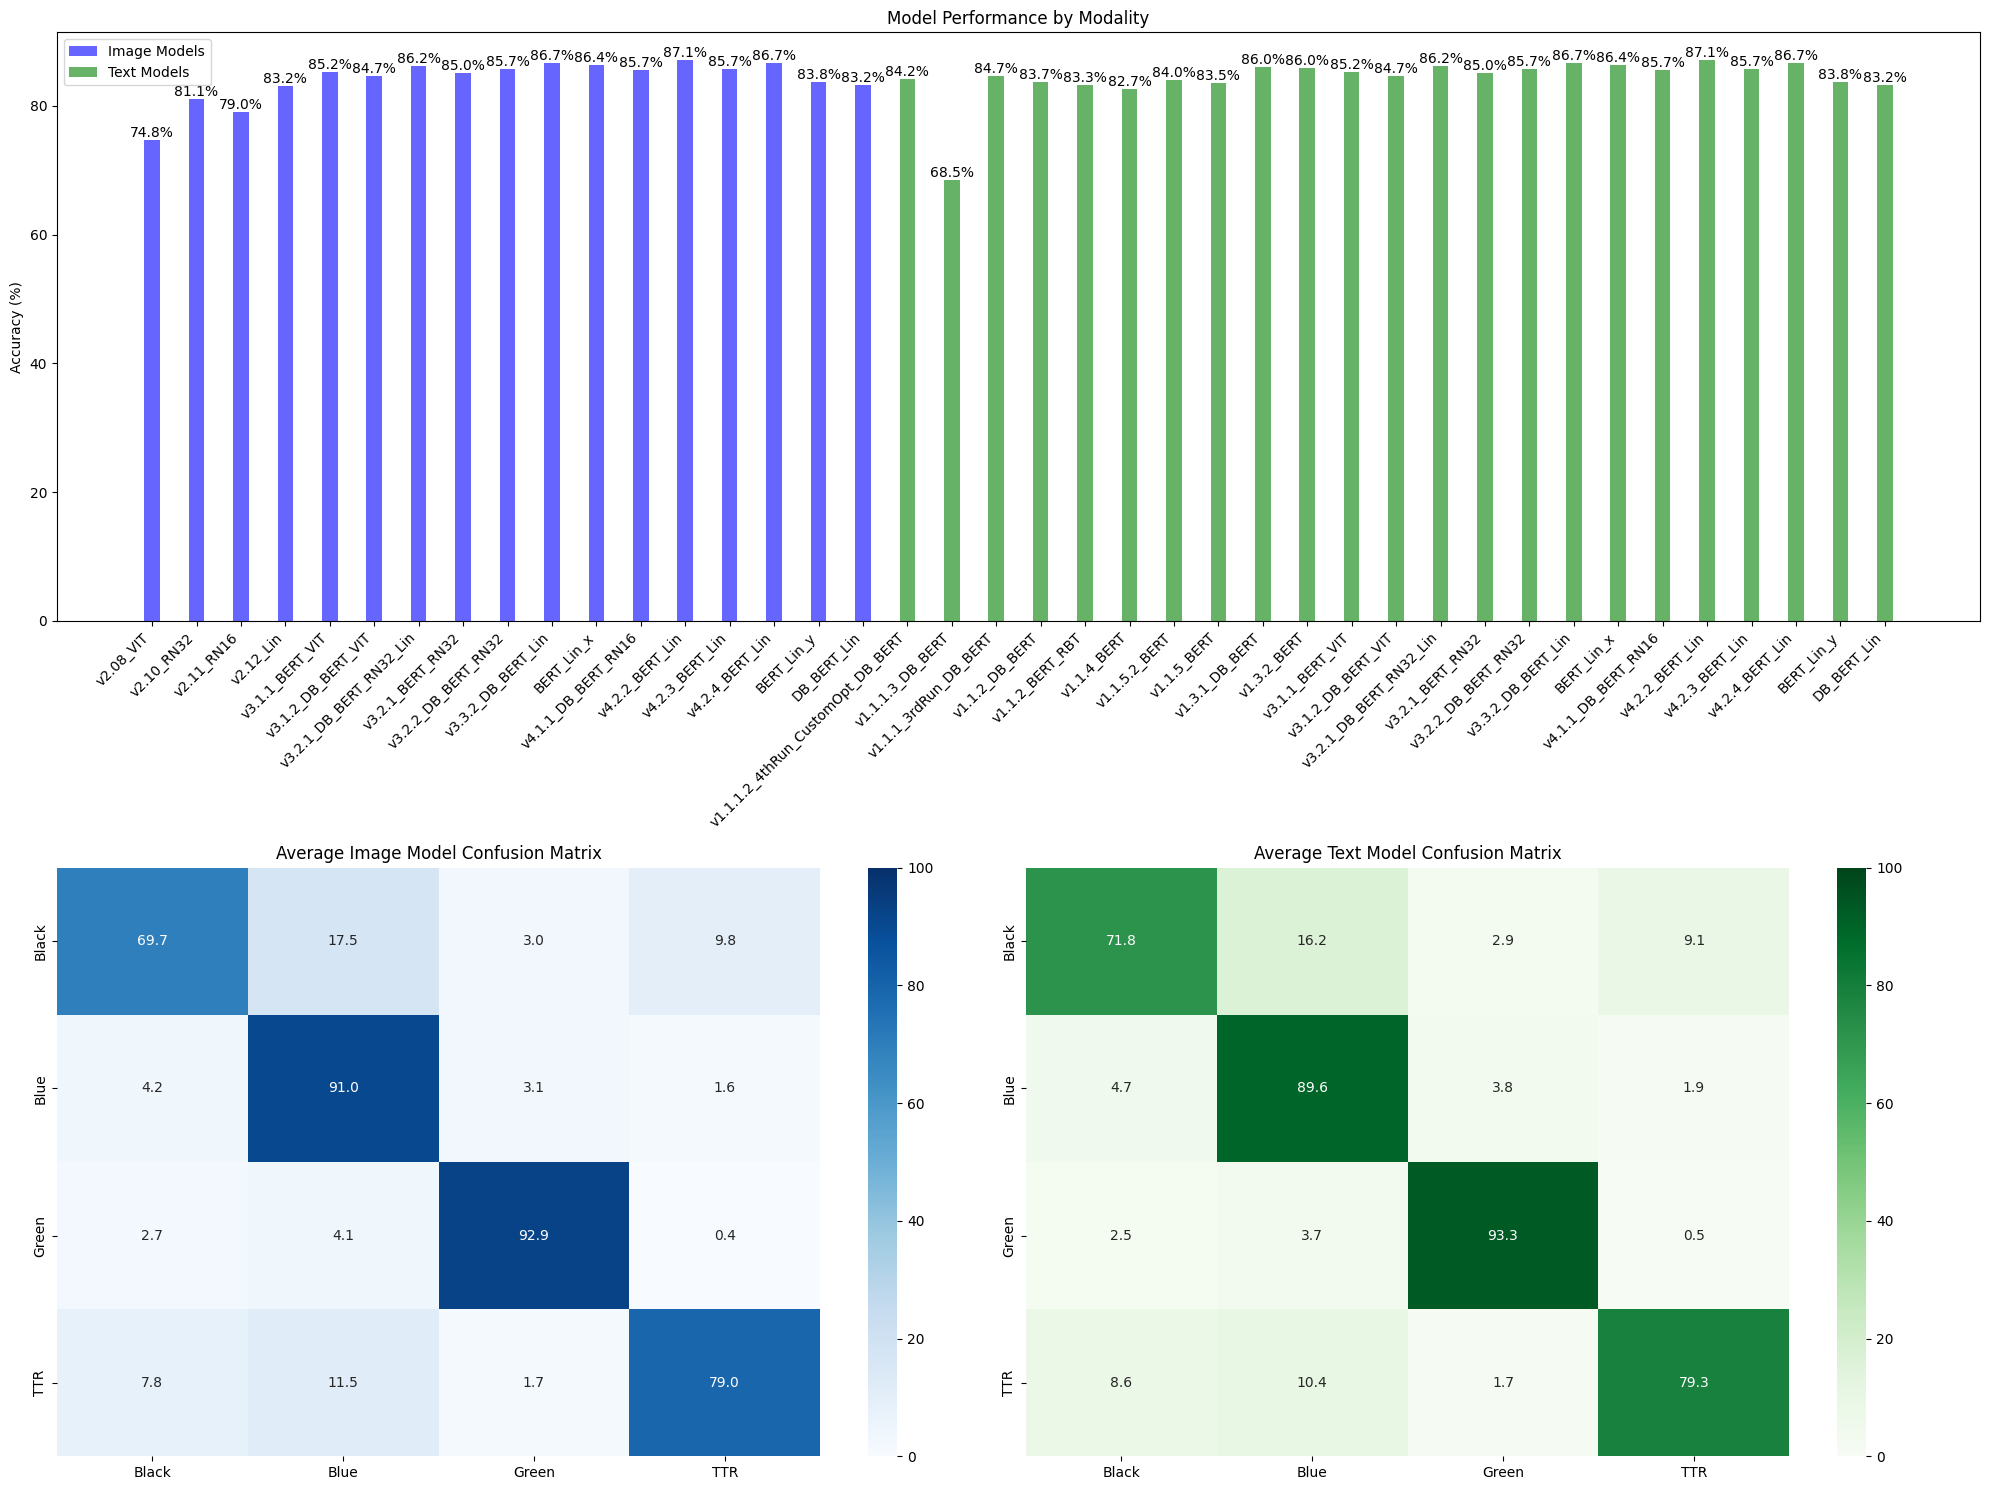

In [11]:
def analyze_model_results(merged_df):
    """Analyze and visualize model performance by modality"""
    # Filter valid prediction columns and extract model names
    pred_cols = [col for col in merged_df.columns if col.startswith('prediction_')]
    model_names = [col.split('prediction_')[1] for col in pred_cols]
    
    # Separate models by type
    image_models = [m for m in model_names if any(x in m.lower() for x in 
                   ['rn32', 'rn16', 'vit', 'lin'])]
    text_models = [m for m in model_names if any(x in m.lower() for x in 
                  ['bert', 'db', 'rbt'])]
    
    # Validate data
    if not image_models or not text_models:
        raise ValueError("No valid image or text models found")
    
    # Create figure
    fig = plt.figure(figsize=(20, 15))
    gs = GridSpec(2, 2, figure=fig)
    
    # 1. Accuracy by Modality
    ax1 = fig.add_subplot(gs[0, :])
    
    # Calculate accuracies
    img_accs = []
    for m in image_models:
        acc = merged_df[f'correct_{m}'].fillna(0).mean() * 100
        img_accs.append(acc)
    
    text_accs = []
    for m in text_models:
        acc = merged_df[f'correct_{m}'].fillna(0).mean() * 100
        text_accs.append(acc)
    
    # Plot bars
    width = 0.35
    x_img = np.arange(len(image_models))
    x_text = np.arange(len(image_models), len(image_models) + len(text_models))
    
    img_bars = ax1.bar(x_img, img_accs, width, label='Image Models', color='blue', alpha=0.6)
    text_bars = ax1.bar(x_text, text_accs, width, label='Text Models', color='green', alpha=0.6)
    
    # Add labels
    for bars in [img_bars, text_bars]:
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}%', ha='center', va='bottom')
    
    ax1.set_xticks(np.concatenate([x_img, x_text]))
    ax1.set_xticklabels(image_models + text_models, rotation=45, ha='right')
    ax1.set_ylabel('Accuracy (%)')
    ax1.set_title('Model Performance by Modality')
    ax1.legend()
    
    # 2. Confusion Matrices
    class_names = ['Black', 'Blue', 'Green', 'TTR']
    
    def get_avg_conf_matrix(models):
        matrices = []
        for model in models:
            try:
                cm = pd.crosstab(
                    merged_df['true_label'],
                    merged_df[f'prediction_{model}'],
                    normalize='index'
                ).reindex(index=range(4), columns=range(4), fill_value=0) * 100
                matrices.append(cm.values)
            except Exception as e:
                print(f"Skipping {model}: {str(e)}")
        return np.mean(matrices, axis=0) if matrices else np.zeros((4, 4))
    
    # Plot matrices
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[1, 1])
    
    img_cm = get_avg_conf_matrix(image_models)
    sns.heatmap(img_cm, annot=True, fmt='.1f', ax=ax2,
                xticklabels=class_names, yticklabels=class_names,
                cmap='Blues', vmin=0, vmax=100)
    ax2.set_title('Average Image Model Confusion Matrix')
    
    text_cm = get_avg_conf_matrix(text_models)
    sns.heatmap(text_cm, annot=True, fmt='.1f', ax=ax3,
                xticklabels=class_names, yticklabels=class_names,
                cmap='Greens', vmin=0, vmax=100)
    ax3.set_title('Average Text Model Confusion Matrix')
    
    plt.tight_layout()
    plt.show()

# Execute
try:
    analyze_model_results(merged_results)
except Exception as e:
    print(f"Error: {str(e)}")

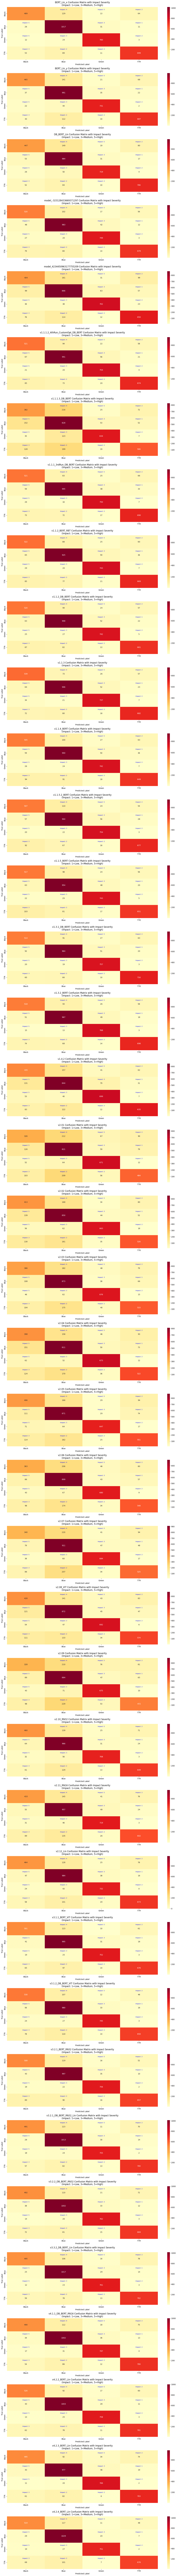


BERT_Lin_x Analysis:
Weighted Error Rate: 0.4197

BERT_Lin_y Analysis:
Weighted Error Rate: 0.5060

DB_BERT_Lin Analysis:
Weighted Error Rate: 0.5415

model_-323128433669371297 Analysis:
Weighted Error Rate: 0.4690

model_4234450963177755209 Analysis:
Weighted Error Rate: 0.7456

v1.1.1.2_4thRun_CustomOpt_DB_BERT Analysis:
Weighted Error Rate: 0.5071

v1.1.1.3_DB_BERT Analysis:
Weighted Error Rate: 1.0149

v1.1.1_3rdRun_DB_BERT Analysis:
Weighted Error Rate: 0.4809

v1.1.2_BERT_RBT Analysis:
Weighted Error Rate: 0.5261

v1.1.2_DB_BERT Analysis:
Weighted Error Rate: 0.5211

v1.1.3 Analysis:
Weighted Error Rate: 0.4937

v1.1.4_BERT Analysis:
Weighted Error Rate: 0.5415

v1.1.5.2_BERT Analysis:
Weighted Error Rate: 0.5138

v1.1.5_BERT Analysis:
Weighted Error Rate: 0.5290

v1.3.1_DB_BERT Analysis:
Weighted Error Rate: 0.4497

v1.3.2_BERT Analysis:
Weighted Error Rate: 0.4500

v1.4.2 Analysis:
Weighted Error Rate: 0.8149

v2.01 Analysis:
Weighted Error Rate: 1.0388

v2.02 Analysis:
Weight

In [12]:
# Define severity matrix (higher number = more harmful misclassification)
# severity_matrix = {
#     'Black': {'Black': 0, 'Blue': 2, 'Green': 3, 'TTR': 1},  # Landfill misclassified as others
#     'Blue': {'Black': 3, 'Blue': 0, 'Green': 2, 'TTR': 1},   # Recyclable wrongly to landfill is very bad
#     'Green': {'Black': 3, 'Blue': 2, 'Green': 0, 'TTR': 1},  # Biodegradable in landfill is very bad
#     'TTR': {'Black': 2, 'Blue': 1, 'Green': 1, 'TTR': 0}     # Other items misclassified
# }

severity_matrix = {
    'Black': {'Black': 0, 'Blue': 4, 'Green': 5, 'TTR': 2},  # Landfill misclassified as others (high penalty for Blue/Green)
    'Blue': {'Black': 5, 'Blue': 0, 'Green': 3, 'TTR': 1},   # Recyclable wrongly to landfill (very high), lesser for Green/TTR
    'Green': {'Black': 5, 'Blue': 3, 'Green': 0, 'TTR': 2},  # Biodegradable to landfill (very high), moderate to Blue/TTR
    'TTR': {'Black': 3, 'Blue': 2, 'Green': 2, 'TTR': 0}     # TTR misclassified as others (moderate penalty)
}
# Create weighted confusion matrix visualization
plt.figure(figsize=(15, 5*len(model_names)))
for idx, model in enumerate(model_names):
    plt.subplot(len(model_names), 1, idx+1)
    
    # Get confusion matrix with correct column name format
    cm = pd.crosstab(
        merged_results['true_label'],
        merged_results[f'prediction_{model}']  # Fixed column name format
    )
    
    # Convert numeric indices to class names
    label_map = {0: 'Black', 1: 'Blue', 2: 'Green', 3: 'TTR'}
    cm.index = [label_map[i] for i in cm.index]
    cm.columns = [label_map[i] for i in cm.columns]
    
    # Create weighted matrix
    weighted_cm = cm.copy()
    for true_class in cm.index:
        for pred_class in cm.columns:
            weight = severity_matrix[true_class][pred_class]
            weighted_cm.loc[true_class, pred_class] *= weight
    
    # Plot heatmap with custom annotations
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd')
    
    # Add severity indicators
    for i in range(len(cm.index)):
        for j in range(len(cm.columns)):
            true_class = cm.index[i]
            pred_class = cm.columns[j]
            if true_class != pred_class:
                weight = severity_matrix[true_class][pred_class]
                plt.text(j+0.5, i+0.2, f'Impact: {weight}', 
                        ha='center', va='center',
                        color='blue', fontsize=8)
    
    plt.title(f'{model} Confusion Matrix with Impact Severity\n(Impact: 1=Low, 3=Medium, 5=High)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# Calculate weighted error rate
for model in model_names:
    weighted_errors = 0
    total_samples = 0
    
    for true_class in severity_matrix:
        for pred_class in severity_matrix[true_class]:
            mask = (merged_results['true_label'].map(label_map) == true_class) & \
                   (merged_results[f'prediction_{model}'].map(label_map) == pred_class)
            count = mask.sum()
            weighted_errors += count * severity_matrix[true_class][pred_class]
            total_samples += count
            
    print(f"\n{model} Analysis:")
    print(f"Weighted Error Rate: {weighted_errors/total_samples:.4f}")